# Quantitative investing with FinBERT, BERT and DistilRoBERTa

In this project, we explore whether large language models can transform unstructured financial news into actionable trading signals. By fine-tuning several transformer architectures on labelled sentiment data and embedding their predictions into a systematic strategy, we research how textual information can be leveraged in quantitative investing.

Goal of this notebook:

1. Load and preprocess labeled financial news for sentiment analysis.
2. Evaluate three transformer models (BERT, FinBERT, DistilRoBERTa) before and after fine-tuning.
3. Select the best model based on macro F1 on the test set.
4. Use the best model to label Dow Jones news for 2025.
5. Backtest simple long-only and long-short trading strategies based on the predicted sentiment.


### Setup: connect Colab to Google Drive and import libraries

In [ ]:
# Mount Google Drive to access saved models and data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Core libraries and plotting

import sys
#sys.path.append('/content/drive/MyDrive/LLM_Project')

#!pip install pandas numpy finnhub-python yfinance requests bt

# Load Project helper libraries
from helperFunction import NewsHelper
from helperFunction import TickerHelper as th
from helperFunction import SentimentHelper as sh
import pandas as pd
import numpy as np
import bt
import json
import matplotlib.pyplot as plt
from datasets import load_dataset

import torch

# Classical ML utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
#  Hugging Face models and training utilities
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoTokenizer
)

from datasets import Dataset


# Place path to data folder
path_to_data = 'data/'

# Provide API keys
finnhub_api_key = "d4g45opr01qgiieo72f0d4g45opr01qgiieo72fg"

# Choose parameters to import data and models or run everything
loadData = True
printPlots_param = True
printStats_param = True

# Select trading universe and time interval (only if loadData = False and trainModels = False)
universe = 'DOW'
start_date = '2025-06-01'
end_date = '2025-11-21'

### Labeled datasets for fine-tuning and evaluation

We work with manually labeled financial news.

In this section we:

- Load the combined sentiment dataset from CSV (prepared in a separate notebook) or optionally rebuild it from three public datasets.
- Merge the sources and rebalance the classes to reduce label skew.
- Split the data into train, validation and test subsets (70/15/15).
- Standardize sentiment classes to: 0 = negative, 1 = neutral, 2 = positive.


In [ ]:
# Directly load data set
# For more information on the data set see  data_processing notebook
if loadData:
    data = pd.read_csv(path_to_data + "balanced_sentiment_data_small.csv")
    data = pd.read_csv("data/balanced_sentiment_data_small.csv")

else:
    # Dataset 1
    # Link: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
    dataset1 = pd.read_csv(path_to_data + "all-data.csv", encoding="ISO-8859-1", header=None)
    dataset1.columns = ['sentiment', 'text']
    sh.sentiment_distribution(dataset1, printPlots_param, printStats_param)

    # Dataset 2
    # Link: https://www.kaggle.com/datasets/ankurzing/aspect-based-sentiment-analysis-for-financial-news
    dataset2 = pd.read_csv(path_to_data + "SEntFiN-v1.1.csv")
    dataset2['Decisions'] = dataset2['Decisions'].apply(json.loads)

    expanded_rows = []
    for index, row in dataset2.iterrows():
        decisions = row['Decisions']

        # Get the first company-sentiment pair (the first item in the dictionary)
        first_company, first_sentiment = list(decisions.items())[0]

        # Create a new row with the title, first company, and its sentiment
        expanded_rows.append({
            'Title': row['Title'],  # Keep the title for the row
            'Company': first_company,  # Use the first company
            'Sentiment': first_sentiment  # Use the sentiment of the first company
        })
    # Create a new DataFrame with expanded rows
    dataset2 = pd.DataFrame(expanded_rows)
    dataset2 = dataset2[['Sentiment', 'Title']]
    dataset2.columns = ['sentiment', 'text']
    sh.sentiment_distribution(dataset2, printPlots_param, printStats_param)

    # Dataset 3
    # Link: https://zenodo.org/records/17628513
    dataset3 = pd.read_csv(path_to_data + "stock_news.csv")
    dataset3 = dataset3[['Label', 'News']]
    dataset3.columns = ['sentiment','text']
    dataset3['sentiment'] = dataset3['sentiment'].replace({1: 'positive', 0: 'neutral', -1: 'negative'})
    sh.sentiment_distribution(dataset3, printPlots_param, printStats_param)

    # Merge datasets
    data = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)

    min_count = data['sentiment'].value_counts().min()
    neutral_df = data[data['sentiment'] == 'neutral'].sample(min_count, random_state=42)
    positive_df = data[data['sentiment'] == 'positive'].sample(min_count, random_state=42)
    negative_df = data[data['sentiment'] == 'negative'].sample(min_count, random_state=42)

    data = pd.concat([neutral_df, positive_df, negative_df], ignore_index=True)
    sh.sentiment_distribution(data, printPlots_param, printStats_param)


### Split the data into train/validation/test samples (75% / 15% / 15%)


In [ ]:
df = data.copy()


label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["sentiment"].map(label_mapping)
df["label"].value_counts()
df["label"] = df["label"].astype(int)

#  Train+Val vs Test (15% test)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df["label"],
    shuffle=True,
    random_state=42,
)

# Train vs Val (from the remaining 85% -> 15% val overall)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1765,               # 0.1765 * 0.85 ≈ 0.15 of full data
    stratify=train_val_df["label"],
    shuffle=True,
    random_state=42,
)

all_results = [] # list to store all scores

# Add "split" column back to full df
df = df.copy()
df["split"] = "train"
df.loc[val_df.index, "split"] = "val"
df.loc[test_df.index, "split"] = "test"

# Optional: save for reuse in all models
#df.to_csv("data/balanced_sentiment_data_small_with_splits.csv", index=False)


# Split into train/val/test dataframes
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

print(train_df["label"].value_counts(), "\n")
print(val_df["label"].value_counts(), "\n")
print(test_df["label"].value_counts(), "\n")



label
1    2689
2    2689
0    2689
Name: count, dtype: int64 

label
1    577
0    577
2    576
Name: count, dtype: int64 

label
2    577
1    576
0    576
Name: count, dtype: int64 



### Convert to HuggingFace datasets

In [ ]:
# Convert Pandas dataframes (train/val/test) to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df[["text", "label"]])
val_ds   = Dataset.from_pandas(val_df[["text", "label"]])
test_ds  = Dataset.from_pandas(test_df[["text", "label"]])

# Base model for this block: vanilla BERT
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Maximum sequence length (tokens longer than this will be truncated)
max_length = 128

def tokenize_function(batch):
    return tokenizer(         # Tokenize a batch of raw texts
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
# Apply tokenizer to each split
train_ds_tok = train_ds.map(tokenize_function, batched=True)
val_ds_tok   = val_ds.map(tokenize_function, batched=True)
test_ds_tok  = test_ds.map(tokenize_function, batched=True)

# Tell HF which columns are inputs
train_ds_tok = train_ds_tok.remove_columns(["text"])
val_ds_tok   = val_ds_tok.remove_columns(["text"])
test_ds_tok  = test_ds_tok.remove_columns(["text"])

# Make sure tensors are returned as PyTorch tensors
train_ds_tok.set_format("torch")
val_ds_tok.set_format("torch")
test_ds_tok.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8067 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Map:   0%|          | 0/1729 [00:00<?, ? examples/s]

### Prepare the BERT Model

In [ ]:
def compute_metrics(eval_pred):
    # eval_pred is a tuple (logits, true_labels) provided by Trainer
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Overall accuracy
    acc = accuracy_score(labels, preds)

    # # Macro-averaged scores (all classes weighted equally)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    # Per-class scores: order will be [0, 1, 2]
    precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )

    return {
        "accuracy": acc,
        "macro_f1": f1_macro,
        "macro_precision": precision_macro,
        "macro_recall": recall_macro,
        "f1_neg": f1_cls[0],
        "f1_neu": f1_cls[1],
        "f1_pos": f1_cls[2],
    }


### Metrics

We use accuracy and macro-averaged precision / recall / F1.
Macro F1 is our main selection criterion, because it treats
negative, neutral and positive classes equally even though
the dataset is imbalanced.

### Load the finetuned BERT

### Fine-tuned BERT on balanced financial news  
 - Load checkpoint from Drive
 - Evaluate on validation set
 - Store metrics for comparison.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the finetuned BERT checkpoint saved in Drive
model_dir_bert = "/content/drive/MyDrive/final_models_kur/bert_base_uncased_finetuned"

# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and classification model from the saved checkpoint
tokenizer_bert = AutoTokenizer.from_pretrained(model_dir_bert)
model_bert = AutoModelForSequenceClassification.from_pretrained(model_dir_bert)
model_bert.to(device)

# Training configuration (used here only so Trainer can evaluate consistently)
batch_size = 16
num_epochs = 3

training_args_bert = TrainingArguments(
    output_dir="./bert_base_uncased_fin_sentiment", # where Trainer stores logs and checkpoints
    eval_strategy="epoch",                          # evaluate on val at end of each epoch
    save_strategy="epoch",                          # save a checkpoint after every epoch
    load_best_model_at_end=True,                    # reload best checkpoint at the end
    metric_for_best_model="macro_f1",               # select checkpoint with highest macro F1
    greater_is_better=True,

    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,

    logging_dir="./logs",
    logging_steps=50,

    report_to="none", # disable Hugging Face online logging
)
# Wrap everything in a Trainer object
trainer = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    compute_metrics=compute_metrics,   # uses macro F1 etc.
    tokenizer = tokenizer_bert
)

# Evaluate the model on the validation dataset
ft_val_results = trainer.evaluate(eval_dataset=val_ds_tok)


all_results.append({
    "backbone": "bert-base-uncased",
    "version": "finetuned",
    "split": "val",
    **ft_val_results
})


# Get predictions on validation set
val_pred_pred = trainer.predict(val_ds_tok)

# True labels and predicted labels
y_true_bert_val = val_pred_pred.label_ids
y_pred_bert_val = np.argmax(val_pred_pred.predictions, axis=-1)

# Optional: class names in the right order
target_names = ["negative", "neutral", "positive"]




/tmp/ipython-input-287740624.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Fine-tuned BERT
print("Accuracy:", accuracy_score(y_true_bert_val, y_pred_bert_val))
print(classification_report(y_true_bert_val, y_pred_bert_val, target_names=target_names, digits=4))
print(all_results)

Accuracy: 0.846820809248555
              precision    recall  f1-score   support

    negative     0.8661    0.8856    0.8757       577
     neutral     0.8309    0.7920    0.8110       577
    positive     0.8424    0.8628    0.8525       576

    accuracy                         0.8468      1730
   macro avg     0.8465    0.8468    0.8464      1730
weighted avg     0.8465    0.8468    0.8464      1730

[{'backbone': 'bert-base-uncased', 'version': 'finetuned', 'split': 'val', 'eval_loss': 0.6319661736488342, 'eval_model_preparation_time': 0.003, 'eval_accuracy': 0.846820809248555, 'eval_macro_f1': 0.8464131944052783, 'eval_macro_precision': 0.8464612223934259, 'eval_macro_recall': 0.8468300677193659, 'eval_f1_neg': 0.8757497857754927, 'eval_f1_neu': 0.8110026619343389, 'eval_f1_pos': 0.8524871355060034, 'eval_runtime': 11.3945, 'eval_samples_per_second': 151.828, 'eval_steps_per_second': 9.566}]


### FinBERT: vanilla vs fine-tuned  
 - Tokenize data with FinBERT tokenizer  
 - Evaluate FinBERT (vanilla)  
 - Later use Fine-tune FinBERT on our training set and compare.


In [ ]:
# FinBERT Tokenization

model_name_finbert_vanilla = "ProsusAI/finbert"
tokenizer_finbert_vanilla = AutoTokenizer.from_pretrained(model_name_finbert_vanilla)

max_length = 128

def tokenize_finbert_vanilla(batch):
    # Standard tokenization for FinBERT
    return tokenizer_finbert_vanilla(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
# Apply tokenizer to train/validation/test splits
train_ds_finbert = train_ds.map(tokenize_finbert_vanilla, batched=True)
val_ds_finbert   = val_ds.map(tokenize_finbert_vanilla, batched=True)
test_ds_finbert  = test_ds.map(tokenize_finbert_vanilla, batched=True)

# Remove raw text, keep only tensors + labels
train_ds_finbert = train_ds_finbert.remove_columns(["text"])
val_ds_finbert   = val_ds_finbert.remove_columns(["text"])
test_ds_finbert  = test_ds_finbert.remove_columns(["text"])

train_ds_finbert.set_format("torch")
val_ds_finbert.set_format("torch")
test_ds_finbert.set_format("torch")




tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/8067 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Map:   0%|          | 0/1729 [00:00<?, ? examples/s]

In [ ]:
# Load FinBERT with its existing (already trained) sentiment head

model_finbert_vanilla = AutoModelForSequenceClassification.from_pretrained(model_name_finbert_vanilla)

# Set up training arguments

batch_size = 16
num_epochs = 3

training_args_finbert_vanilla = TrainingArguments(
    output_dir="./finbert_finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,

    logging_dir="./logs_finbert",
    logging_steps=50,
    report_to="none",
)


trainer_finbert_vanilla = Trainer(
    model=model_finbert_vanilla,
    args=training_args_finbert_vanilla,
    train_dataset=train_ds_finbert,
    eval_dataset=val_ds_finbert,
    compute_metrics=compute_metrics,
)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# Check Vanilla FinBERT on Validation sample

# Evaluate vanilla (off-the-shelf) FinBERT on your validation set
vanilla_finbert_val = trainer_finbert_vanilla.evaluate(eval_dataset=val_ds_finbert)
print("Vanilla FinBERT on validation:", vanilla_finbert_val)

# Optionally also compute the full classification report:
val_pred_vanilla_finbert = trainer_finbert_vanilla.predict(val_ds_finbert)
y_true_val_vanilla_finbert = val_pred_vanilla_finbert.label_ids
y_pred_val_vanilla_finbert = np.argmax(val_pred_vanilla_finbert.predictions, axis=-1)



Vanilla FinBERT on validation: {'eval_loss': 3.0760843753814697, 'eval_model_preparation_time': 0.0026, 'eval_accuracy': 0.12080924855491329, 'eval_macro_f1': 0.11700951986197385, 'eval_macro_precision': 0.11428487821880018, 'eval_macro_recall': 0.12086282014249951, 'eval_f1_neg': 0.05166051660516605, 'eval_f1_neu': 0.10366398570151922, 'eval_f1_pos': 0.1957040572792363, 'eval_runtime': 11.4902, 'eval_samples_per_second': 150.563, 'eval_steps_per_second': 9.486}


In [ ]:
target_names = ["negative", "neutral", "positive"]  # according to your label mapping
print("Accuracy:", accuracy_score(y_true_val_vanilla_finbert, y_pred_val_vanilla_finbert))
print("Vanilla FinBERT – classification report (val):")
print(classification_report(y_true_val_vanilla_finbert, y_pred_val_vanilla_finbert, target_names=target_names, digits=4))

# Store results
all_results.append({
    "backbone": model_name_finbert_vanilla,
    "version": "vanilla",
    "split": "val",
    **{f"eval_{k}": v for k, v in vanilla_finbert_val.items()}
})


Accuracy: 0.12080924855491329
Vanilla FinBERT – classification report (val):
              precision    recall  f1-score   support

    negative     0.0552    0.0485    0.0517       577
     neutral     0.1070    0.1005    0.1037       577
    positive     0.1806    0.2135    0.1957       576

    accuracy                         0.1208      1730
   macro avg     0.1143    0.1209    0.1170      1730
weighted avg     0.1142    0.1208    0.1170      1730



### Load the finetuned FinBERT



In [ ]:
# Load our fine-tuned FinBERT checkpoint from Drive
model_dir_finbert = "/content/drive/MyDrive/final_models_kur/finbert_finetuned_new"


tokenizer_finbert_ft = AutoTokenizer.from_pretrained(model_dir_finbert)
model_finbert_ft = AutoModelForSequenceClassification.from_pretrained(model_dir_finbert)
model_finbert_ft.to(device)


# Load the trainer
batch_size = 16
num_epochs = 3

training_args_finbert_ft = TrainingArguments(
    output_dir="./finbert_finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,

    logging_dir="./logs_finbert",
    logging_steps=50,
    report_to="none",
)
# initialize the Trainer
trainer_finbert_ft = Trainer(

    model=model_finbert_ft,
    args=training_args_finbert_ft,
    train_dataset=train_ds_finbert,
    eval_dataset=test_ds_finbert, # we use this Trainer just for evaluation
    tokenizer=tokenizer,
)




/tmp/ipython-input-3224464955.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_finbert_ft = Trainer(


In [ ]:
# Evaluate fine-tuned FinBERT on validation
ft_finbert_val = trainer_finbert_ft.evaluate(eval_dataset=val_ds_finbert)
print("Fine-tuned FinBERT on validation:", ft_finbert_val)

# Classification report after fine-tuning
val_pred_ft_finbert = trainer_finbert_ft.predict(val_ds_finbert)
y_true_val_ft_finbert = val_pred_ft_finbert.label_ids
y_pred_val_ft_finbert = np.argmax(val_pred_ft_finbert.predictions, axis=-1)


Fine-tuned FinBERT on validation: {'eval_loss': 0.6216083765029907, 'eval_model_preparation_time': 0.0027, 'eval_runtime': 11.0178, 'eval_samples_per_second': 157.019, 'eval_steps_per_second': 9.893}


In [ ]:
print("Accuracy:", accuracy_score(y_true_val_ft_finbert, y_pred_val_ft_finbert))
print("Fine-tuned FinBERT – classification report (val):")
print(classification_report(y_true_val_ft_finbert, y_pred_val_ft_finbert, target_names=target_names, digits=4))

# Store results
all_results.append({
    "backbone": model_finbert_ft,
    "version": "finetuned",
    "split": "val",
    **{f"eval_{k}": v for k, v in ft_finbert_val.items()}
})

Accuracy: 0.8578034682080925
Fine-tuned FinBERT – classification report (val):
              precision    recall  f1-score   support

    negative     0.8862    0.8908    0.8885       577
     neutral     0.8211    0.8111    0.8160       577
    positive     0.8655    0.8715    0.8685       576

    accuracy                         0.8578      1730
   macro avg     0.8576    0.8578    0.8577      1730
weighted avg     0.8576    0.8578    0.8577      1730



### FinBERT results on validation (macro F1):

- Vanilla FinBERT: 0.1170 macro F1 (almost random because our labels differ from the original FinBERT task).
- Fine-tuned FinBERT: 0.8577 macro F1.

So for our labeled financial-news dataset, fine-tuning is essential. The off-the-shelf FinBERT head does not match our 3-class sentiment labels, but after fine-tuning the model becomes our best performer on the validation set.


### DistilRoBERTa

In [ ]:
model_name_distil_vanilla = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer_distil_vanilla = AutoTokenizer.from_pretrained(model_name_distil_vanilla)

max_length = 128  # keep same sequence length as for BERT / FinBERT

def tokenize_distil_vanilla(batch):
    return tokenizer_distil_vanilla(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# Reuse your existing HF Datasets: train_ds, val_ds, test_ds (text + label)
train_ds_distil = train_ds.map(tokenize_distil_vanilla, batched=True)
val_ds_distil   = val_ds.map(tokenize_distil_vanilla, batched=True)
test_ds_distil  = test_ds.map(tokenize_distil_vanilla, batched=True)

# Remove raw text – model only needs tensors + labels
train_ds_distil = train_ds_distil.remove_columns(["text"])
val_ds_distil   = val_ds_distil.remove_columns(["text"])
test_ds_distil  = test_ds_distil.remove_columns(["text"])

train_ds_distil.set_format("torch")
val_ds_distil.set_format("torch")
test_ds_distil.set_format("torch")





tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/8067 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Map:   0%|          | 0/1729 [00:00<?, ? examples/s]

In [ ]:
# Load Vanilla Model DistilRoBERTa and Trainer

# Load the financial DistilRoBERTa with its existing sentiment head
model_distil_vanilla = AutoModelForSequenceClassification.from_pretrained(model_name_distil_vanilla)


batch_size = 16
num_epochs = 3

training_args_distil_vanilla = TrainingArguments(
    output_dir="./distilroberta_financial_finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1", # same selection criterion as for other models
    greater_is_better=True,
    greater_is_better=True,

    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,

    logging_dir="./logs_distil",
    logging_steps=50,
    report_to="none",
)


trainer_distil_vanilla = Trainer(
    model= model_distil_vanilla,
    args=training_args_distil_vanilla,
    train_dataset=train_ds_distil,
    eval_dataset=val_ds_distil,
    compute_metrics=compute_metrics,  # same as before
)




config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [ ]:
# Check Vanilla DistilRoBRTa on validation Sample

# HF's built-in evaluation dict (contains macro_f1 etc.)
vanilla_distil_val = trainer_distil_vanilla.evaluate(eval_dataset=val_ds_distil)
print("Vanilla DistilRoBERTa on validation:", vanilla_distil_val)

# Classification report for nice per-class overview
val_pred_vanilla_distil = trainer_distil_vanilla.predict(val_ds_distil)
y_true_val_distil_vanilla = val_pred_vanilla_distil.label_ids
y_pred_val_distil_vanilla = np.argmax(val_pred_vanilla_distil.predictions, axis=-1)

target_names = ["negative", "neutral", "positive"]


Vanilla DistilRoBERTa on validation: {'eval_loss': 1.5551371574401855, 'eval_model_preparation_time': 0.0021, 'eval_accuracy': 0.7670520231213873, 'eval_macro_f1': 0.7692586748318192, 'eval_macro_precision': 0.7795995086426478, 'eval_macro_recall': 0.7670381603440529, 'eval_f1_neg': 0.8101028999064547, 'eval_f1_neu': 0.7327044025157232, 'eval_f1_pos': 0.7649687220732797, 'eval_runtime': 5.2326, 'eval_samples_per_second': 330.617, 'eval_steps_per_second': 20.831}


In [ ]:
print("Accuracy:", accuracy_score(y_pred_val_distil_vanilla, y_true_val_distil_vanilla))
print("Vanilla DistilRoBERTa – classification report (val):")
print(classification_report(y_true_val_distil_vanilla, y_pred_val_distil_vanilla,
                            target_names=target_names, digits=4))

# Store results
all_results.append({
    "backbone": model_distil_vanilla,
    "version": "vanilla",
    "split": "val",
    **{f"eval_{k}": v for k, v in vanilla_distil_val.items()}
})


Accuracy: 0.7670520231213873
Vanilla DistilRoBERTa – classification report (val):
              precision    recall  f1-score   support

    negative     0.8801    0.7504    0.8101       577
     neutral     0.6705    0.8076    0.7327       577
    positive     0.7882    0.7431    0.7650       576

    accuracy                         0.7671      1730
   macro avg     0.7796    0.7670    0.7693      1730
weighted avg     0.7796    0.7671    0.7693      1730



In [ ]:
# Path to your saved model
model_dir_distil_ft = "/content/drive/MyDrive/final_models_kur/distillroberta_finetuned_new"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
tokenizer_distil_ft = AutoTokenizer.from_pretrained(model_dir_distil_ft)
model_distil_ft = AutoModelForSequenceClassification.from_pretrained(model_dir_distil_ft)
#model_distil_ft.to(device)

# Reload the Trainer with the model and tokenizer
training_args_distil_ft = TrainingArguments(
    output_dir='./results',                   # Directory to save results (if needed)
    per_device_eval_batch_size=8,             # Adjust batch size
    per_device_train_batch_size=8,            # Adjust batch size for training
    eval_strategy="epoch",                    # Evaluation strategy
    logging_dir='./logs',
    report_to="none",
)
# Re-create training arguments for the fine-tuned model
trainer_distil_ft = Trainer(
    model=model_distil_ft,                     # Your fine-tuned model
    args=training_args_distil_ft,              # Training arguments
    tokenizer=tokenizer_distil_ft,             # Tokenizer to handle text preprocessing
    eval_dataset=val_ds_distil
)






/tmp/ipython-input-2223195054.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distil_ft = Trainer(


In [ ]:
# Evaluate fine-tuned DistilRoBERTa on validation
ft_distil_val = trainer_distil_ft.evaluate(eval_dataset=val_ds_distil)

print("Fine-tuned DistilRoBERTa on validation:", ft_distil_val)

# Classification report after fine-tuning
val_pred_ft_distil = trainer_distil_ft.predict(val_ds_distil)
y_true_val_ft_distil = val_pred_ft_distil.label_ids
y_pred_val_ft_distil = np.argmax(val_pred_ft_distil.predictions, axis=-1)



Fine-tuned DistilRoBERTa on validation: {'eval_loss': 0.41111770272254944, 'eval_model_preparation_time': 0.0027, 'eval_runtime': 5.4414, 'eval_samples_per_second': 317.931, 'eval_steps_per_second': 39.879}


In [ ]:
print("Accuracy:", accuracy_score(y_pred_val_ft_distil, y_true_val_ft_distil))
print("Fine-tuned DistilRoBERTa – classification report (val):")
print(classification_report(y_true_val_ft_distil, y_pred_val_ft_distil,
                            target_names=target_names, digits=4))

# Store fine-tuned results
all_results.append({
    "backbone": model_distil_ft,
    "version": "finetuned",
    "split": "val",
    **{f"eval_{k}": v for k, v in ft_distil_val.items()}
})

Accuracy: 0.8566473988439306
Fine-tuned DistilRoBERTa – classification report (val):
              precision    recall  f1-score   support

    negative     0.8872    0.8856    0.8864       577
     neutral     0.8135    0.8163    0.8149       577
    positive     0.8696    0.8681    0.8688       576

    accuracy                         0.8566      1730
   macro avg     0.8567    0.8567    0.8567      1730
weighted avg     0.8567    0.8566    0.8567      1730



### DistilRoBERTa results on validation (macro F1):

- Vanilla DistilRoBERTa: 0.7693 macro F1.  
- Fine-tuned DistilRoBERTa: 0.8567 macro F1.

DistilRoBERTa already performs well out-of-the-box, because it is pretrained on financial news and its sentiment head matches our 3-class setup. Fine-tuning on our labeled dataset still adds a clear boost of about 0.09 macro F1, bringing it close to the fine-tuned FinBERT and clearly above the BERT baseline on the validation set.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

test_results = []

# 1) Finetuned BERT on Test-Set
print("===== BERT (finetuned) - TEST =====")
ft_test_bert = trainer.evaluate(eval_dataset=test_ds_tok)

all_results.append({
    "backbone": "bert-base-uncased",
    "version": "finetuned",
    "split": "test",
    **ft_test_bert
})
test_results.append(all_results[-1])

test_pred_bert = trainer.predict(test_ds_tok)
y_true_bert_test = test_pred_bert.label_ids
y_pred_bert_test = test_pred_bert.predictions.argmax(axis=1)

print("Accuracy:", accuracy_score(y_true_bert_test, y_pred_bert_test))
print(classification_report(
    y_true_bert_test,
    y_pred_bert_test,
    target_names=["negative", "neutral", "positive"],
    digits=4
))


# 2) Finetuned FinBERT on Test-Set
print("\n===== FinBERT (finetuned) - TEST =====")
ft_test_finbert = trainer_finbert_ft.evaluate(eval_dataset=test_ds_finbert)

all_results.append({
    "backbone": "FinBERT",
    "version": "finetuned",
    "split": "test",
    **ft_test_finbert
})
test_results.append(all_results[-1])

test_pred_finbert = trainer_finbert_ft.predict(test_ds_finbert)
y_true_finbert_test = test_pred_finbert.label_ids
y_pred_finbert_test = test_pred_finbert.predictions.argmax(axis=1)

print("Accuracy:", accuracy_score(y_true_finbert_test, y_pred_finbert_test))
print(classification_report(
    y_true_finbert_test,
    y_pred_finbert_test,
    target_names=["negative", "neutral", "positive"],
    digits=4
))


# 3) Finetuned DistilRoBERTa on Test-Set
print("\n===== DistilRoBERTa (finetuned) - TEST =====")
ft_test_distil = trainer_distil_ft.evaluate(eval_dataset=test_ds_distil)

all_results.append({
    "backbone": "DistilRoBERTa",
    "version": "finetuned",
    "split": "test",
    **ft_test_distil
})
test_results.append(all_results[-1])

test_pred_distil = trainer_distil_ft.predict(test_ds_distil)
y_true_distil_test = test_pred_distil.label_ids
y_pred_distil_test = test_pred_distil.predictions.argmax(axis=1)

print("Accuracy:", accuracy_score(y_true_distil_test, y_pred_distil_test))
print(classification_report(
    y_true_distil_test,
    y_pred_distil_test,
    target_names=["negative", "neutral", "positive"],
    digits=4
))


===== BERT (finetuned) – TEST =====


Accuracy: 0.8461538461538461
              precision    recall  f1-score   support

    negative     0.8881    0.8958    0.8920       576
     neutral     0.8010    0.8038    0.8024       576
    positive     0.8491    0.8388    0.8439       577

    accuracy                         0.8462      1729
   macro avg     0.8461    0.8462    0.8461      1729
weighted avg     0.8461    0.8462    0.8461      1729


===== FinBERT (finetuned) – TEST =====


Accuracy: 0.86524002313476
              precision    recall  f1-score   support

    negative     0.8957    0.9097    0.9027       576
     neutral     0.8360    0.8056    0.8205       576
    positive     0.8625    0.8804    0.8714       577

    accuracy                         0.8652      1729
   macro avg     0.8647    0.8652    0.8648      1729
weighted avg     0.8647    0.8652    0.8648      1729


===== DistilRoBERTa (finetuned) – TEST =====


Accuracy: 0.8507807981492193
              precision    recall  f1-score   support

    negative     0.8885    0.8993    0.8939       576
     neutral     0.8105    0.8021    0.8063       576
    positive     0.8524    0.8510    0.8517       577

    accuracy                         0.8508      1729
   macro avg     0.8505    0.8508    0.8506      1729
weighted avg     0.8505    0.8508    0.8506      1729



### Test set evaluation

In this step we freeze all hyperparameters and evaluate the three fine-tuned models on the held-out test subset (15 percent of the data).  
The code below

1. runs `Trainer.evaluate` and `Trainer.predict` on the test set for each model,
2. prints a `classification_report` with precision, recall and F1 per class,
3. stores the Hugging Face evaluation metrics in `all_results` for the final summary table.

Macro F1 on the test set

- BERT (finetuned): accuracy 0.8462, macro F1 0.8461  
- FinBERT (finetuned): accuracy 0.8652, macro F1 0.8648  
- DistilRoBERTa (finetuned): accuracy 0.8508, macro F1 0.8506  

**FinBERT** remains the best model on the unseen test data.
  
Compared to the generic BERT baseline, FinBERT gains about 2 percentage points in macro F1, which confirms that a finance-specific pretraining plus fine-tuning helps.  
DistilRoBERTa is slightly better than BERT and slightly worse than FinBERT, which fits its design as a lighter, faster model with a small performance trade-off.


### Classification of unknown text

In [ ]:
from transformers import TextClassificationPipeline

# load Dow-News
if loadData:
    trading_news = pd.read_csv(data + "dow_news_all_data.csv",
                               usecols=[1, 2, 3])  # datetime, summary, ticker
    trading_news.columns = ["datetime", "summary", "ticker"]
    trading_news["datetime"] = pd.to_datetime(trading_news["datetime"])
else:
    tickers = th.get_tickers(universe)
    news_downloader = NewsHelper(finnhub_api_key)
    trading_news = news_downloader.get_group_news(tickers, start_date, end_date)

# Pipeline with Finetuned FinBERT
sentiment_pipe = TextClassificationPipeline(
    model=model_finbert_ft,
    tokenizer=tokenizer_finbert_ft,
    device=0 if torch.cuda.is_available() else -1,
)

# Get text from "summary"
texts = trading_news["summary"].astype(str).tolist()

# Run model on all News
preds = sentiment_pipe(texts, truncation=True, max_length=128)

# Map HuggingFace-Labels -> 0/1/2
label_map = {"negative": 0, "neutral": 1, "positive": 2}
trading_news["label"] = [label_map[p["label"]] for p in preds]

# optional
trading_news = trading_news[["datetime", "summary", "ticker", "label"]]

trading_news.head()


Device set to use cuda:0


,datetime,summary,ticker,label
0,2021-04-26,Berkshire Hathaway is the ultimate Warren Buff...,AAPL,0
1,2022-05-20,"Whether you're a value, growth, or momentum in...",AAPL,0
2,2025-04-06,"Amid hype over artificial intelligence, the be...",AAPL,1
3,2025-06-01,(Bloomberg) -- Samsung Electronics Co. is near...,AAPL,1
4,2025-06-01,Madison Diversified Income Fund was well posit...,AAPL,1


In [ ]:
label_trading_news = (
    trading_news.groupby(['datetime', 'ticker'], as_index=False)
      ['label']
      .mean()
      .rename(columns={'label': 'avg_label'})
)
label_trading_news['datetime'] = pd.to_datetime(label_trading_news['datetime'])
label_trading_news = label_trading_news[label_trading_news['datetime'] >= '2025-01-01']

### Price data

For the backtest we need daily close prices for all stocks in our universe.

- `loadData = True`: read a pre-saved CSV from disk (faster, reproducible).
- `loadData = False`: download fresh prices for the selected `universe` and
  `[start_date, end_date]` using our helper functions (`TickerHelper`).

In both cases we end up with:

- `price_data`: DataFrame indexed by date  
- columns = tickers in the selected universe  
- values = daily close prices (used by the `bt` backtesting library)


In [ ]:
# Load historical prices for the selected universe and period
if loadData:
    # Use cached CSV prices (faster, avoids repeated API calls)
    price_data = pd.read_csv(
        path_to_data + "prices_" + universe + "_" + start_date + "_" + end_date + ".csv",
        index_col = 0,
        parse_dates=True)
else:
    # Otherwise, download fresh prices via our helper
    tickers = th.get_tickers(universe)
    price_data = th.get_filtered_stock_data(tickers, start_date, end_date, 'Close')

### Backtesting: turning sentiment into trading signals

We now use the predicted sentiment to construct daily trading strategies:

1. Aggregate news by day and ticker and compute an average sentiment score
   `avg_label` (0 = negative, 1 = neutral, 2 = positive).

2. Build a **long-only** portfolio:
   - go long on stocks with `avg_label ≥ 1.5` (strongly positive sentiment),
   - equally weight all selected stocks on that day,
   - no position if no stock passes the filter.

3. Build a **long-short** portfolio:
   - go long on `avg_label ≥ 1.5`,
   - go short on `avg_label < 0.5` (strongly negative sentiment),
   - equal weight within the long and short sides, dollar-neutral each day.
   
4. Compare both strategies to an **equal-weight buy-and-hold** benchmark
   using the `bt` backtesting library.


In [ ]:
# Long-Only Portfolio
mask = label_trading_news['avg_label'] >= 1.5

# Assign weights
n_selected = mask.groupby(label_trading_news['datetime']).transform('sum')

label_trading_news['weight'] = np.where(
    mask & (n_selected > 0),   # only if selected and there is at least one selected that day
    1.0 / n_selected,          # equal weight among selected
    0.0                        # otherwise no position
)

weights = label_trading_news.pivot(index='datetime', columns='ticker', values='weight').fillna(0.0)

# Create strategy
long_only_strategy = bt.Strategy(
    "Long_Only",
    [
        bt.algos.RunDaily(),            # run every day
        bt.algos.SelectAll(),           # all assets (columns of prices)
        bt.algos.WeighTarget(weights),  # our custom weight matrix
        bt.algos.Rebalance()
    ]
)

# Create backtest
long_only_backtest = bt.Backtest(long_only_strategy, price_data)

In [ ]:
# Long Short Portfolio
is_long  = label_trading_news['avg_label'] >= 1.5
is_short = label_trading_news['avg_label'] < 0.5

# Assign weights
n_long = is_long.groupby(label_trading_news['datetime']).transform('sum')
n_short = is_short.groupby(label_trading_news['datetime']).transform('sum')

weights_array = np.where(
    is_long & (n_long > 0),
    1.0 / n_long,
    np.where(
        is_short & (n_short > 0),
        -1.0 / n_short,
        0.0
    )
)
label_trading_news['weight'] = weights_array
ls_weights = label_trading_news.pivot(index='datetime', columns='ticker', values='weight').fillna(0.0)

common_cols = price_data.columns.intersection(ls_weights.columns)
price_data = price_data[common_cols]
ls_weights = ls_weights[common_cols]
ls_weights = ls_weights.reindex(price_data.index).fillna(0.0)

# Create strategy
long_short_strategy = bt.Strategy(
    "Long_Short",
    [
        bt.algos.RunDaily(),                # run every day
        bt.algos.SelectAll(),               # all assets (columns)
        bt.algos.WeighTarget(ls_weights),   # our long–short weights
        bt.algos.Rebalance()
    ]
)

# Create backtest
long_short_backtest = bt.Backtest(long_short_strategy, price_data)


In [ ]:
# Buy and Hold Benchmark
benchmark_strategy = bt.Strategy(
    "Buy_Hold_Benchmark",
    [
        bt.algos.RunDaily(),      # run every trading day
        bt.algos.SelectAll(),     # use all columns (all assets)
        bt.algos.WeighEqually(),  # equal weights across selected assets
        bt.algos.Rebalance()      # execute the rebalance
    ]
)

# Create the backtest
benchmark_backtest = bt.Backtest(benchmark_strategy, price_data)

100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Stat                 Long_Only    Long_Short    Buy_Hold_Benchmark
-------------------  -----------  ------------  --------------------
Start                2025-06-01   2025-06-01    2025-06-01
End                  2025-11-20   2025-11-20    2025-11-20
Risk-free rate       0.00%        0.00%         0.00%

Total Return         11.11%       -0.41%        8.27%
Daily Sharpe         1.59         0.04          1.73
Daily Sortino        2.99         0.07          3.11
CAGR                 25.07%       -0.86%        18.38%
Max Drawdown         -5.89%       -9.92%        -3.99%
Calmar Ratio         4.25         -0.09         4.61

MTD                  -1.64%       3.26%         -2.64%
3m                   1.16%        3.34%         1.48%
6m                   -            -             -
YTD                  11.11%       -0.41%        8.27%
1Y                   -            -             -
3Y (ann.)            -            -             -
5Y (ann.)            -            -             -
10Y 

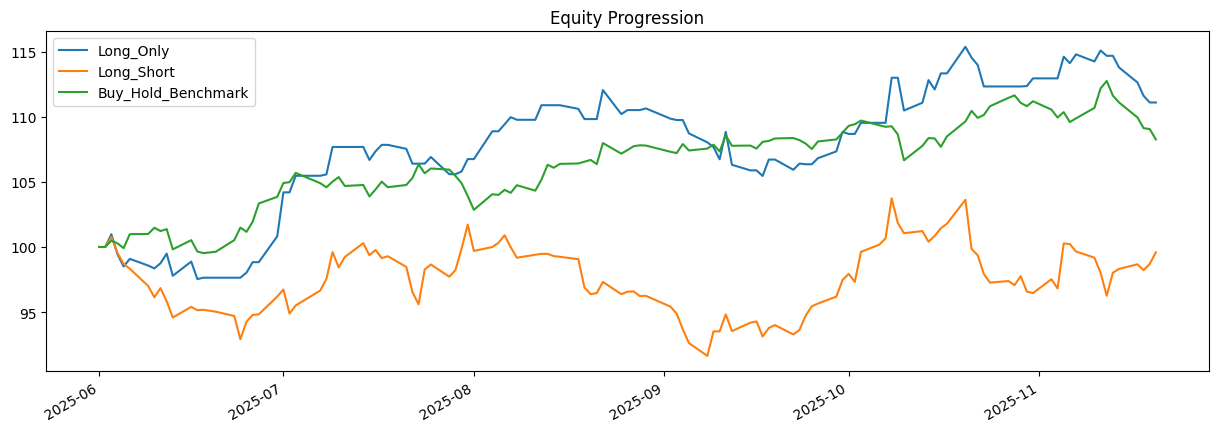

In [ ]:
# Run the backtest
result = bt.run(long_only_backtest, long_short_backtest, benchmark_backtest)

# See stats and plot equity curves
if printPlots_param:
    result.plot()

if printStats_param:
    print(result.display())

## Conclusion

In this project we built an end-to-end pipeline that turns financial news into trading signals.

**Main modelling results**

- We compared three transformer models for 3-class financial sentiment:
  BERT (general-purpose baseline), FinBERT (finance-specific) and DistilRoBERTa (smaller, faster).
- All models were evaluated with macro F1 to give equal weight to the three classes
  negative, neutral and positive, which is important because the dataset is reasonably balanced.
- On the validation set, fine-tuning clearly improved performance whenever the original
  head was not aligned with our labels:
  - FinBERT: from about 0.12 macro F1 (essentially random on our labels) to about 0.86.
  - DistilRoBERTa: from about 0.77 to about 0.86 macro F1.
  - BERT: already worked well as a generic classifier and showed a small but consistent gain.
- On the held-out test set, all fine-tuned models reached solid and very similar performance.
  FinBERT achieved the best macro F1 (≈0.865), followed by DistilRoBERTa (≈0.851)
  and BERT (≈0.846). This is why we used fine-tuned FinBERT for the trading experiment.

**Backtesting results**

- We applied the best model to Dow Jones news in 2025 and aggregated predictions
  into a daily sentiment score per stock.
- A simple long-only strategy that buys stocks with strongly positive average sentiment
  outperformed an equal-weight buy-and-hold benchmark over the sample:
  higher total return and better risk-adjusted performance (Sharpe and Calmar ratios),
  although with higher volatility and drawdowns.
- A symmetric long-short strategy based on very positive versus very negative sentiment
  did not perform well in this short sample, which suggests that negative signals
  were noisier or that timing this market is harder to exploit.

**Limitations and future work**

- The backtest covers only a few months and one index universe, so results
  should be seen as a proof of concept rather than robust evidence.
- We ignored transaction costs, slippage and realistic position-sizing
  constraints.
- The sentiment model uses only short summaries, not full articles and does not
  incorporate other information such as technical indicators derived from price and volume, fundamentals or macro data.

**Overall takeaway**

Fine-tuned transformer models, especially FinBERT, can accurately classify financial news into negative, neutral and positive sentiment. When these predictions are turned into simple trading rules, they already produce signals that beat a naive benchmark in our small experiment. With more data, richer model features and more realistic portfolio construction, this approach could become a useful building block for quantitative investing based on news flow.
